# Series Temporales

Las series temporales son una serie de eventos ordenados con respecto del **tiempo** y esta en funcion de la misma serie; 
por ejemplo el precio de la bolsa de valores del dia de hoy esta relacionada con su precio del dia de ayer,los enfermos de covid durante unos meses, el creciemiento de la economia, etc.

La serie temporal puede descomponerse en 4 componentes:
   + La media 
   + La estacionalidad  - o ciclo
   + La tendencia
   + El ruido - que es una variable random en nuestros datos 

Podemos usar de la libreria *statsmodels* la funcion *seasonal_decompose* que nos permite plotear su descomposicion

Al trabajar con una serie temporal tenemos en python tenermos que tener el indice como con formato date para poder manipular la serie

In [1]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

from random import gauss
from random import seed
from pandas import Series
from pandas.plotting import autocorrelation_plot

In [2]:
occupancy = pd.read_csv('data/occupancy.csv')
occupancy.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,2/2/2015 14:00,23.7000,26.272,585.200000,749.200000,0.004764,1
1,2/2/2015 15:00,23.7180,26.290,578.400000,760.400000,0.004773,1
2,2/2/2015 16:00,23.7300,26.230,572.666667,769.666667,0.004765,1
3,2/2/2015 17:00,23.7225,26.125,493.750000,774.750000,0.004744,1
4,2/2/2015 18:00,23.7540,26.200,488.600000,779.000000,0.004767,1


### Ya que es una serie de tiempo nos aseguramos que el indice sea un formato date

In [3]:
occupancy.date = pd.to_datetime(occupancy.date)
occupancy.index = pd.DatetimeIndex(occupancy.date, freq='H')
occupancy.index

DatetimeIndex(['2015-02-02 14:00:00', '2015-02-02 15:00:00',
               '2015-02-02 16:00:00', '2015-02-02 17:00:00',
               '2015-02-02 18:00:00', '2015-02-02 19:00:00',
               '2015-02-02 20:00:00', '2015-02-02 21:00:00',
               '2015-02-02 22:00:00', '2015-02-02 23:00:00',
               ...
               '2015-05-24 04:00:00', '2015-05-24 05:00:00',
               '2015-05-24 06:00:00', '2015-05-24 07:00:00',
               '2015-05-24 08:00:00', '2015-05-24 09:00:00',
               '2015-05-24 10:00:00', '2015-05-24 11:00:00',
               '2015-05-24 12:00:00', '2015-05-24 13:00:00'],
              dtype='datetime64[ns]', name='date', length=2664, freq='H')

Procedemos a descomponer la serie de tiempo en sus componentes

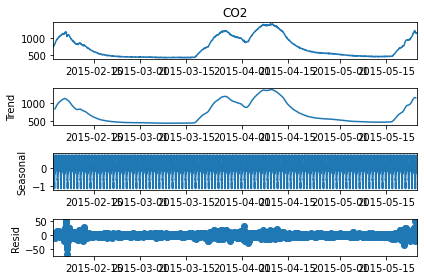

In [4]:
res = sm.tsa.seasonal_decompose(occupancy.CO2)
resplot = res.plot()

Esta descomposicion nos dira de arriba a abajo:
    Un media de los valores de la misma serie
    La tendencia de la misma positiva negativa etc.
    Su estacionalidad, si tiene patron de repeticion cada cierto tiempo
    y un termino de ruido el cual siempre esta presente como variaciones random de la misma informacion 

#### Noise

In [5]:
# generador de numeros aletorios
seed(1)
# Creando una serie 'noise'
series = [gauss(0.0, 1.0) for i in range(1000)]
series = Series(series)

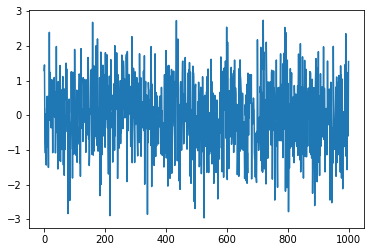

In [6]:
# Plot
series.plot()
plt.show()

## Autoregresion

Para analizar series de tiempo el modelo autoregresivo usara las mismas observaciones de la serie un tiempo o rezago antes para poder predecir los siguientes periodos. Es decir que nuestra variable a explicar, estara explicada por ella misma en uno o varios rezagos.

Podemos buscar la relacion de nuestra serie usando lag_plot de pandas, este plot mostrara la serie contra si misma en un rezago uno; es decir t y t-1.


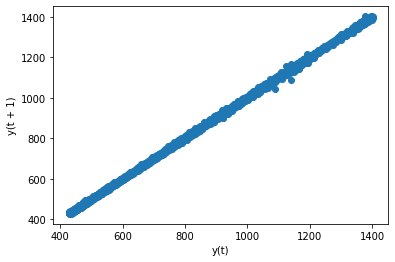

In [7]:
from pandas.plotting import lag_plot

lag_plot(occupancy.CO2);

Como se puede observar hay relacion entre una y otra de manera positiva, por lo que usar la misma serie con rezago podria ayudarnos a predecir mas adelante.
Usaremos la funcion AR que sera para autoregresion, con n rezagos AR(n)

Al igual que en los modelos anteriores dividiremos la data pra entrenar el modelo y posteriormente predecir, en este caso usaremos un rezago para nuestro modelo autoregresivo

In [8]:
from statsmodels.tsa.ar_model import AR # importamos el modelo 

train, test = occupancy.CO2[:-10], occupancy.CO2[-10:] #dividimos la data
model = AR(occupancy.CO2) #definimos la variable que se usara para el modelo
model_fit = model.fit(maxlag=1) #entrenamos con un rezago
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False) #Predecimos

C:\Users\GralG\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\ar_model.py:791: FutureWarning: 
statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

  warnings.warn(AR_DEPRECATION_WARN, 

In [9]:
data_f = pd.DataFrame({'observed':test, 'predicted':predictions})

<AxesSubplot:xlabel='date'>

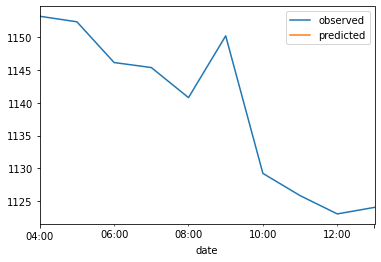

In [10]:
data_f.plot()

### Estacionareidad
Una serie de tiempo se considera que es estacionaria si su media y su varianza no cambian con el tiempo, de esta manera se podra predecir con mas exactitud, existen varias forma de comprobar si la variable es estacionaria o no;
podemos descomponerla visualmente, cacular la desviacion estandard en el tiempo, y podemos usar la prueba **Dickey-Fuller** aumentada:
Dicha prueba tiene como premisas:

+ H0: Los serie no es estacionaria
+ H1: La data es estacionaria

In [13]:
from statsmodels.tsa.stattools import adfuller

In [14]:
help(adfuller)

Help on function adfuller in module statsmodels.tsa.stattools:

adfuller(x, maxlag=None, regression='c', autolag='AIC', store=False, regresults=False)
    Augmented Dickey-Fuller unit root test.
    
    The Augmented Dickey-Fuller test can be used to test for a unit root in a
    univariate process in the presence of serial correlation.
    
    Parameters
    ----------
    x : array_like, 1d
        The data series to test.
    maxlag : int
        Maximum lag which is included in test, default 12*(nobs/100)^{1/4}.
    regression : {"c","ct","ctt","nc"}
        Constant and trend order to include in regression.
    
        * "c" : constant only (default).
        * "ct" : constant and trend.
        * "ctt" : constant, and linear and quadratic trend.
        * "nc" : no constant, no trend.
    
    autolag : {"AIC", "BIC", "t-stat", None}
        Method to use when automatically determining the lag.
    
        * if None, then maxlag lags are used.
        * if "AIC" (default) or 

In [15]:
from statsmodels.tsa.stattools import adfuller

adfuller(occupancy.CO2)

(0.5521309458043582,
 0.9863743437108111,
 0,
 2663,
 {'1%': -3.432807985211508,
  '5%': -2.8626259540301553,
  '10%': -2.5673480904338657},
 nan)

## Media Movil

Son parecidos a los modelos autoregresivos ya que de igual manera explican la variable misma pero con el ruido blanco de los datos pasados. Los modelos de media movil se de notan como MA(q) donde 'q' es el numero de ruido blanco de observaciones pasadas.
Ambos modelos se pueden usar en conjunto de manera que podemos usar un modelo ARMA que tendra como paremetros,el numero de rezagos a ver al pasado, y el numero de medias moviles de igual manera a usar 
Podemos usar este modelo desde la libreria statsmodels.. Dicha funcion usara ambos componentes, numero de rezagos y medias moviles.

Aunque podemos usar solo la media movil sin rezagos podriamos tener problemas. Por ejemplo:

In [16]:
from statsmodels.tsa.arima_model import ARMA

model = ARMA(occupancy.CO2, order=(0, 1))
model_fit = model.fit(disp=False)
predictions = model_fit.predict(len(occupancy.CO2)-3, len(occupancy.CO2)-1)

C:\Users\GralG\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


In [17]:
pd.DataFrame({'observed':occupancy.CO2[-3:], 'predicted':predictions})

,observed,predicted
date,,
2015-05-24 11:00:00,1125.8,926.765752
2015-05-24 12:00:00,1123.0,915.381600
2015-05-24 13:00:00,1124.0,923.900313


# Usando ARMA completo

Como se pudo observar, al usar solo una media movil nos mostro una prediccion erronea ya que la media movil no se ha movido.USaremos el modelo completo con REzagos y medias moviles

In [18]:
from statsmodels.tsa.arima_model import ARMA

# fit model
model = ARMA(occupancy.CO2, order=(2, 1))
model_fit = model.fit(disp=False)
# make prediction
predictions = model_fit.predict(len(occupancy.CO2)-3, len(occupancy.CO2)-1)

C:\Users\GralG\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


In [19]:
pd.DataFrame({'observed':occupancy.CO2[-3:], 'predicted':predictions})

,observed,predicted
date,,
2015-05-24 11:00:00,1125.8,1128.223208
2015-05-24 12:00:00,1123.0,1124.659595
2015-05-24 13:00:00,1124.0,1121.741340


# Sistemas de recomendación

#### Filtro Colaborativo

Técnica utilizada por algunos sistemas recomendadores, los cuales  suelen incluir conjuntos de datos muy grandes. Hay dos tipos de filtros colaborativos:

+ Basados en Usuarios (User-based):

Se basan en una premisa simple de similitud entre gustos, es decir, en que si una persona A tiene la misma opinión que una persona B sobre un tema, A es más probable que tenga la misma opinión que B en otro tema diferente que la opinión que tendría una persona elegida azar. 

Tiene ciertos inconvenientes. 
Requiere evaluaciones previas, sin algunas evaluaciones de usuarios, no se tienen pistas sobre las evaluaciones de los nuevos usuarios.
No es una matriz densa, usualmente los usuarios dan su rating sobre algunos items y no sobre toda la base de datos, lo que puede dificultar algunos casos por falta de datos pero puede ayudar ya que no se tiene que hacer los cálculos para todas las combinaciones posibles.
Altos costos si los perfiles de usuarios cambian, si los gustos cambian o hay ruido en los datos (ejemplo, 2 personas usan la misma cuenta en el sistema) todo el modelo del sistema debe ser recalculado.

+ Basados en Items (Items-based):

Buscan la similitud entre elementos, utilizan distribuciones de calificación por artículo, no por usuario, lo que puede ayudar a sobrellevar algunos de los problemas de los modelos User-based. Con más usuarios que elementos, cada elemento tiende a tener más calificaciones que cada usuario, por lo que la calificación promedio de un elemento generalmente no cambia rápidamente. Esto conduce a distribuciones de calificación más estables en el modelo, por lo que no es necesario reconstruir el modelo con tanta frecuencia. Cuando los usuarios consumen y luego califican un artículo, los elementos similares de ese elemento se seleccionan del modelo de sistema existente y se agregan a las recomendaciones del usuario.

### Ejemplo Peliculas (User-based)

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [21]:
from scipy.spatial.distance import pdist       # calcula distancias entre puntos
from scipy.spatial.distance import squareform  # convierte a una matriz cuadrada

In [25]:
ratings=pd.read_csv('data/movie_ratings.csv').set_index('Movie')
ratings.head()

,Brandon,Emily,Cleo,Rusty,Samantha
Movie,,,,,
Aquaman,4,1,2,2,2
Avengers: Infinity War,2,5,2,5,5
Black Panther,5,2,5,1,1
Bohemian Rhapsody,2,3,4,4,1
Deadpool 2,3,2,4,5,1


In [26]:
def plot(m1, m2):
    
    x=ratings.T[m1]  # ratings de las peliculas
    y=ratings.T[m2]
    
    n=list(ratings.T.index)  # nombres de los usuarios
    
    plt.figure(figsize=(10, 5))
    
    plt.scatter(x, y, s=0) # scatter vacio...para luego poner los nombres
    
    plt.title('Espacio para {} VS. {}'.format(m1, m2), fontsize=14)
    plt.xlabel(m1, fontsize=14)
    plt.ylabel(m2, fontsize=14)
    
    for i,e in enumerate(n):
        plt.annotate(e, (x[i], y[i]), fontsize=12)  # se escribe el nombre en las posiciones correspondientes
    plt.show();

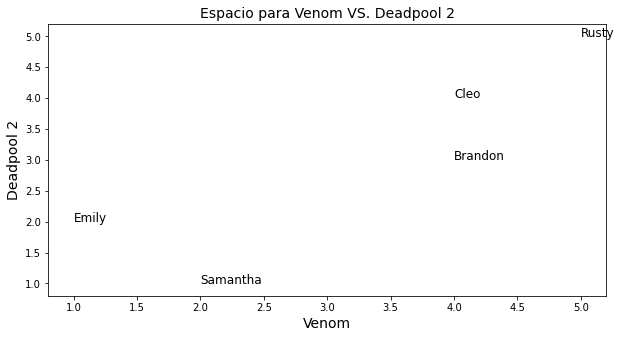

In [27]:
plot('Venom', 'Deadpool 2')

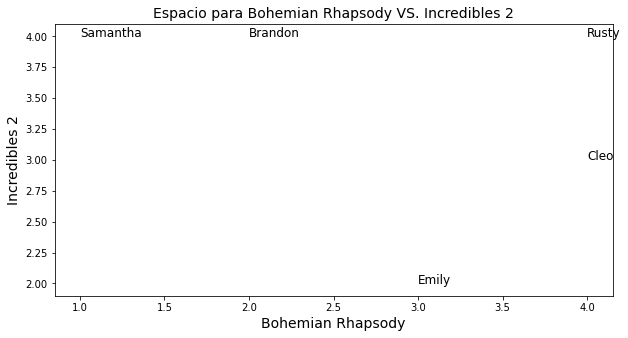

In [28]:
plot('Bohemian Rhapsody', 'Incredibles 2')

In [29]:
ratings.T

Movie,Aquaman,Avengers: Infinity War,Black Panther,Bohemian Rhapsody,Deadpool 2,Fantastic Beasts: The Crimes of Grindelwald,Incredibles 2,Jurassic World: Fallen Kingdom,Mission: Impossible – Fallout,Venom
Brandon,4,2,5,2,3,5,4,2,5,4
Emily,1,5,2,3,2,4,2,3,5,1
Cleo,2,2,5,4,4,1,3,5,4,4
Rusty,2,5,1,4,5,2,4,4,3,5
Samantha,2,5,1,1,1,5,4,5,2,2


In [30]:
distancias=squareform(pdist(ratings.T, 'euclidean'))    # distancia entre usuarios

distancias   # pertenecen al intervalo [0, +inf) entre mas cerca de cero seran los mas parecidos

array([[0.        , 6.63324958, 6.        , 7.41619849, 7.48331477],
       [6.63324958, 0.        , 6.92820323, 6.40312424, 5.09901951],
       [6.        , 6.92820323, 0.        , 5.56776436, 8.24621125],
       [7.41619849, 6.40312424, 5.56776436, 0.        , 6.70820393],
       [7.48331477, 5.09901951, 8.24621125, 6.70820393, 0.        ]])

In [31]:
similitud=1/(1+distancias) 
#Para nuestro uso de caso pasaremos los valores a que entre mas grande el numero mayor similitud

similitudes=pd.DataFrame(similitud, index=ratings.columns, columns=ratings.columns)

similitudes  # pertenecen al intervalo (0, 1)

,Brandon,Emily,Cleo,Rusty,Samantha
Brandon,1.000000,0.131006,0.142857,0.118818,0.117878
Emily,0.131006,1.000000,0.126132,0.135078,0.163961
Cleo,0.142857,0.126132,1.000000,0.152259,0.108152
Rusty,0.118818,0.135078,0.152259,1.000000,0.129732
Samantha,0.117878,0.163961,0.108152,0.129732,1.000000


##### metricas de distancia

https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html

https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.spatial.distance.squareform.html

https://docs.scipy.org/doc/scipy-0.14.0/reference/spatial.distance.html

**euclidea**

$$d=\sqrt{x^2 + y^2}$$

$$d=\sqrt{x_1^2 + x_2^2 + \ldots + x_n^2}$$

**cityblock - manhattan**

$$d=x + y$$

**similitud del coseno**

In [32]:
%matplotlib inline
import scipy.spatial.distance as distance
import numpy as np
import math

**producto escalar**

$$(1, 2, 3)·(2, 1, 1)= 1*2 + 2*1 + 3*1 =7$$

In [33]:
def dot(v1, v2):
    return sum(map(lambda x: x[0]*x[1], zip(v1,v2)))

$$\cos{\theta}=\frac{v1·v2}{|v1|·|v2|}$$

donde:

$|V1|=\sqrt{x_1^2+x_2^2+x_3^2}$

![](euc_cos.png)

### Generar recomendaciones

In [41]:
tom={'Aquaman': 2, 
     'Avengers: Infinity War':1, 
     'Black Panther':5,
     'Bohemian Rhapsody':5, 
     'Deadpool 2':2,
     'Fantastic Beasts: The Crimes of Grindelwald':3, 
     'Incredibles 2':3,
     'Jurassic World: Fallen Kingdom':4, 
     'Mission: Impossible – Fallout':3,
     'Venom':3}

In [42]:
ratings['Tom']=pd.Series(tom)

distancias=squareform(pdist(ratings.T, 'euclidean')) 

similitud=1/(1+distancias)

similitudes=pd.DataFrame(similitud, index=ratings.columns, columns=ratings.columns)

similitudes

,Brandon,Emily,Cleo,Rusty,Samantha,Tom
Brandon,1.000000,0.131006,0.142857,0.118818,0.117878,0.156613
Emily,0.131006,1.000000,0.126132,0.135078,0.163961,0.135078
Cleo,0.142857,0.126132,1.000000,0.152259,0.108152,0.217129
Rusty,0.118818,0.135078,0.152259,1.000000,0.129732,0.126132
Samantha,0.117878,0.163961,0.108152,0.129732,1.000000,0.116961
Tom,0.156613,0.135078,0.217129,0.126132,0.116961,1.000000


In [43]:
n_ratings=pd.read_csv('data/movie_ratings2.csv').set_index('Movie')

n_ratings

,Brandon,Emily,Cleo,Rusty,Samantha
Movie,,,,,
Beauty and the Beast,2,5,2,5,2
Despicable Me 3,4,5,5,1,2
Guardians of the Galaxy Vol. 2,4,1,5,4,2
Jumanji: Welcome to the Jungle,4,3,3,2,5
Spider-Man: Homecoming,1,3,5,2,5
Star Wars: The Last Jedi,5,4,1,2,2
The Fate of the Furious,2,1,3,3,3
Thor: Ragnarok,4,3,4,1,5
Wolf Warrior 2,5,3,2,3,4


#### Score de similitud

In [44]:
similitudes

,Brandon,Emily,Cleo,Rusty,Samantha,Tom
Brandon,1.000000,0.131006,0.142857,0.118818,0.117878,0.156613
Emily,0.131006,1.000000,0.126132,0.135078,0.163961,0.135078
Cleo,0.142857,0.126132,1.000000,0.152259,0.108152,0.217129
Rusty,0.118818,0.135078,0.152259,1.000000,0.129732,0.126132
Samantha,0.117878,0.163961,0.108152,0.129732,1.000000,0.116961
Tom,0.156613,0.135078,0.217129,0.126132,0.116961,1.000000


In [49]:
simil_score

Cleo        0.217129
Brandon     0.156613
Emily       0.135078
Rusty       0.126132
Samantha    0.116961
Name: Tom, dtype: float64

In [50]:
n_ratings

,Brandon,Emily,Cleo,Rusty,Samantha
Movie,,,,,
Beauty and the Beast,2,5,2,5,2
Despicable Me 3,4,5,5,1,2
Guardians of the Galaxy Vol. 2,4,1,5,4,2
Jumanji: Welcome to the Jungle,4,3,3,2,5
Spider-Man: Homecoming,1,3,5,2,5
Star Wars: The Last Jedi,5,4,1,2,2
The Fate of the Furious,2,1,3,3,3
Thor: Ragnarok,4,3,4,1,5
Wolf Warrior 2,5,3,2,3,4


In [51]:
simil_score=similitudes['Tom'].sort_values(ascending=False)[1:]

reco=n_ratings.copy()

for n,s in dict(simil_score).items():
    print(n,s)
    reco[n]=reco[n]*s
    
reco['Total']=reco.sum(axis=1)
reco.sort_values('Total', ascending=False)

Cleo 0.21712927295533244
Brandon 0.1566130288262323
Emily 0.13507810593582123
Rusty 0.1261319836228832
Samantha 0.11696132920126338


,Brandon,Emily,Cleo,Rusty,Samantha,Total
Movie,,,,,,
Despicable Me 3,0.626452,0.675391,1.085646,0.126132,0.233923,2.747544
Wonder Woman,0.626452,0.405234,0.868517,0.378396,0.467845,2.746445
Thor: Ragnarok,0.626452,0.405234,0.868517,0.126132,0.584807,2.611142
Guardians of the Galaxy Vol. 2,0.626452,0.135078,1.085646,0.504528,0.233923,2.585627
Jumanji: Welcome to the Jungle,0.626452,0.405234,0.651388,0.252264,0.584807,2.520145
Spider-Man: Homecoming,0.156613,0.405234,1.085646,0.252264,0.584807,2.484564
Wolf Warrior 2,0.783065,0.405234,0.434259,0.378396,0.467845,2.468799
Beauty and the Beast,0.313226,0.675391,0.434259,0.630660,0.233923,2.287458
Star Wars: The Last Jedi,0.783065,0.540312,0.217129,0.252264,0.233923,2.026693


In [52]:
# con otra metrica

distancias=squareform(pdist(ratings.T, 'cosine')) 

similitud=1/(1+distancias)

similitudes=pd.DataFrame(similitud, index=ratings.columns, columns=ratings.columns)

simil_score=similitudes['Tom'].sort_values(ascending=False)[1:]

reco=n_ratings.copy()

for n,s in dict(simil_score).items():
    reco[n]=reco[n]*s
    
reco['Total']=reco.sum(axis=1)
reco.sort_values('Total', ascending=False)

,Brandon,Emily,Cleo,Rusty,Samantha,Total
Movie,,,,,,
Wonder Woman,3.615951,2.511274,3.809728,2.532334,3.168375,15.637662
Despicable Me 3,3.615951,4.185457,4.762161,0.844111,1.584187,14.991867
Thor: Ragnarok,3.615951,2.511274,3.809728,0.844111,3.960468,14.741533
Wolf Warrior 2,4.519939,2.511274,1.904864,2.532334,3.168375,14.636786
Jumanji: Welcome to the Jungle,3.615951,2.511274,2.857296,1.688222,3.960468,14.633212
Guardians of the Galaxy Vol. 2,3.615951,0.837091,4.762161,3.376445,1.584187,14.175835
Spider-Man: Homecoming,0.903988,2.511274,4.762161,1.688222,3.960468,13.826113
Beauty and the Beast,1.807976,4.185457,1.904864,4.220556,1.584187,13.703040
Star Wars: The Last Jedi,4.519939,3.348365,0.952432,1.688222,1.584187,12.093146


In [53]:
distancias=squareform(pdist(ratings.T, 'cityblock')) 

similitud=1/(1+distancias)

similitudes=pd.DataFrame(similitud, index=ratings.columns, columns=ratings.columns)

simil_score=similitudes['Tom'].sort_values(ascending=False)[1:]

reco=n_ratings.copy()

for n,s in dict(simil_score).items():
    reco[n]=reco[n]*s
    
reco['Total']=reco.sum(axis=1)
reco.sort_values('Total', ascending=False)

,Brandon,Emily,Cleo,Rusty,Samantha,Total
Movie,,,,,,
Wonder Woman,0.2500,0.166667,0.4,0.176471,0.20,1.193137
Despicable Me 3,0.2500,0.277778,0.5,0.058824,0.10,1.186601
Guardians of the Galaxy Vol. 2,0.2500,0.055556,0.5,0.235294,0.10,1.140850
Thor: Ragnarok,0.2500,0.166667,0.4,0.058824,0.25,1.125490
Spider-Man: Homecoming,0.0625,0.166667,0.5,0.117647,0.25,1.096814
Jumanji: Welcome to the Jungle,0.2500,0.166667,0.3,0.117647,0.25,1.084314
Wolf Warrior 2,0.3125,0.166667,0.2,0.176471,0.20,1.055637
Beauty and the Beast,0.1250,0.277778,0.2,0.294118,0.10,0.996895
Star Wars: The Last Jedi,0.3125,0.222222,0.1,0.117647,0.10,0.852369


In [54]:
distancias=squareform(pdist(ratings.T, 'canberra')) 

similitud=1/(1+distancias)

similitudes=pd.DataFrame(similitud, index=ratings.columns, columns=ratings.columns)

simil_score=similitudes['Tom'].sort_values(ascending=False)[1:]

reco=n_ratings.copy()

for n,s in dict(simil_score).items():
    reco[n]=reco[n]*s
    
reco['Total']=reco.sum(axis=1)
reco.sort_values('Total', ascending=False)

,Brandon,Emily,Cleo,Rusty,Samantha,Total
Movie,,,,,,
Wonder Woman,1.171548,0.766423,1.495549,0.865583,0.943997,5.243100
Despicable Me 3,1.171548,1.277372,1.869436,0.288528,0.471999,5.078883
Guardians of the Galaxy Vol. 2,1.171548,0.255474,1.869436,1.154110,0.471999,4.922568
Thor: Ragnarok,1.171548,0.766423,1.495549,0.288528,1.179996,4.902044
Jumanji: Welcome to the Jungle,1.171548,0.766423,1.121662,0.577055,1.179996,4.816685
Wolf Warrior 2,1.464435,0.766423,0.747774,0.865583,0.943997,4.788213
Spider-Man: Homecoming,0.292887,0.766423,1.869436,0.577055,1.179996,4.685798
Beauty and the Beast,0.585774,1.277372,0.747774,1.442638,0.471999,4.525557
Star Wars: The Last Jedi,1.464435,1.021898,0.373887,0.577055,0.471999,3.909274


In [55]:
distancias=squareform(pdist(ratings.T, 'jaccard')) 

similitud=1/(1+distancias)

similitudes=pd.DataFrame(similitud, index=ratings.columns, columns=ratings.columns)

simil_score=similitudes['Tom'].sort_values(ascending=False)[1:]

reco=n_ratings.copy()

for n,s in dict(simil_score).items():
    reco[n]=reco[n]*s
    
reco['Total']=reco.sum(axis=1)
reco.sort_values('Total', ascending=False)

,Brandon,Emily,Cleo,Rusty,Samantha,Total
Movie,,,,,,
Wonder Woman,2.105263,1.578947,2.352941,1.764706,2.105263,9.907121
Despicable Me 3,2.105263,2.631579,2.941176,0.588235,1.052632,9.318885
Jumanji: Welcome to the Jungle,2.105263,1.578947,1.764706,1.176471,2.631579,9.256966
Thor: Ragnarok,2.105263,1.578947,2.352941,0.588235,2.631579,9.256966
Wolf Warrior 2,2.631579,1.578947,1.176471,1.764706,2.105263,9.256966
Guardians of the Galaxy Vol. 2,2.105263,0.526316,2.941176,2.352941,1.052632,8.978328
Beauty and the Beast,1.052632,2.631579,1.176471,2.941176,1.052632,8.854489
Spider-Man: Homecoming,0.526316,1.578947,2.941176,1.176471,2.631579,8.854489
Star Wars: The Last Jedi,2.631579,2.105263,0.588235,1.176471,1.052632,7.554180


# Survival Analysis

Originalmente diseñado para cuantificar y medir la esperanza de vida de un individuo, por ejemplo, si queremos conocer la probabilidad de mortalidad si se contrae cierta enfermedad. Se puede usar para varios propósitos: esperanza de vida, fallos mecánicos, retención de clientes o para estimar el periodo de recuperación de una enfermedad.

Hay tres requerimientos:
+ Campo con el número de veces que ocurre el evento (un count)
+ Campo temporal
+ Campo de agrupación


**Estimador Kaplan-Meier**

https://en.wikipedia.org/wiki/Kaplan%E2%80%93Meier_estimator



$$S(t) = \prod_{i:t_i<t}(1-\frac{d_i}{n_i})$$


donde :

$d_i = $ número de muertes

$n_i = $ número de individuos

In [56]:
import chart_studio.plotly as py
import cufflinks as cf
cf.go_offline()

In [61]:
data=pd.read_csv('data/churn.csv')
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,MonthLevel,TotalLevel,TenureLevel,ChurnBinary
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,Month-to-month,Yes,Electronic check,29.85,29.85,No,Low,Very Low,New,0.0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,One year,No,Mailed check,56.95,1889.50,No,Low,Moderate,Loyal,0.0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,Low,Very Low,New,1.0
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,One year,No,Bank transfer (automatic),42.30,1840.75,No,Low,Moderate,Loyal,0.0
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,Moderate,Very Low,New,1.0


In [62]:
data.tenure

0        1
1       34
2        2
3       45
4        2
        ..
7027    24
7028    72
7029    11
7030     4
7031    66
Name: tenure, Length: 7032, dtype: int64

In [69]:
from lifelines import KaplanMeierFitter

In [70]:
def survival(data, group_field, time_field, event_field):
    model = KaplanMeierFitter()
    results = []
    
    for i in data[group_field].unique():
        group = data[data[group_field]==i]
        T = group[time_field]
        E = group[event_field]
        model.fit(T, E, label=str(i))
        results.append(model.survival_function_)
    
    survival = pd.concat(results, axis=1)
    return survival

In [71]:
rates=survival(data, 'gender', 'tenure', 'ChurnBinary')

rates.iplot(kind='line', xTitle='Permanencia(meses)', yTitle='Tasa de retencion',
            title='Tasa de retencion por genero y permanencia')

In [72]:
rates=survival(data, 'SeniorCitizen', 'tenure', 'ChurnBinary')

rates.iplot(kind='line', xTitle='Permanencia(meses)', yTitle='Tasa de retencion',
            title='Tasa de retencion por jubilacion y permanencia')

In [73]:
rates=survival(data, 'InternetService', 'tenure', 'ChurnBinary')

rates.iplot(kind='line', xTitle='Permanencia(meses)', yTitle='Tasa de retencion',
            title='Tasa de retencion por servicio y permanencia')

In [74]:
rates=survival(data, 'Contract', 'tenure', 'ChurnBinary')

rates.iplot(kind='line', xTitle='Permanencia(meses)', yTitle='Tasa de retencion',
            title='Tasa de retencion por contrato y permanencia')

# MongoDB Atlas

In [ ]:
import pymongo

def token(token):
    with open(token, 'r') as f:
        t=f.readlines()[0].split('\n')[0]
    return t

In [ ]:
cliente=pymongo.MongoClient('mongodb+srv://Yonatan:{}@mambacluster-v9uol.mongodb.net/test?retryWrites=true&w=majority'.format(token('mongoatlas.txt')))

In [ ]:
db=cliente.test

original=db.original

cursor=original.find()

list(cursor)